# Imports

In [60]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0, "..")
from league_data import LeagueData

# Definitions

In [61]:
leagueID = 1041760
standings_url_template = (
    "https://fantasy.premierleague.com/api/leagues-classic/{leagueID}/standings/"
)
history_url_template = (
    "https://fantasy.premierleague.com/api/entry/{manager_id}/history/"
)
picks_url_template = (
    "https://fantasy.premierleague.com/api/entry/{manager_id}/event/{gw}/picks/"
)
transfers_url_template = (
    "https://fantasy.premierleague.com/api/entry/{manager_id}/transfers/"
)
bootstrap_static_url = "https://fantasy.premierleague.com/api/bootstrap-static/"
live_url_template = "https://fantasy.premierleague.com/api/event/{gw}/live/"

# Functions

In [62]:
def std(x):
    return np.std(x)

# Gaussian plot class

In [63]:
class Gaussian:
    @staticmethod
    def plot(
        mean,
        std,
        lower_bound=None,
        upper_bound=None,
        resolution=None,
        title=None,
        x_label=None,
        y_label=None,
        legend_label=None,
        legend_location="best",
    ):

        lower_bound = (mean - 4 * std) if lower_bound is None else lower_bound
        upper_bound = (mean + 4 * std) if upper_bound is None else upper_bound
        resolution = 100

        title = title or "Gaussian Distribution"
        x_label = x_label or "x"
        y_label = y_label or "N(x|μ,σ)"
        legend_label = legend_label or "μ={}, σ={}".format(mean, std)
        legend_label = None

        X = np.linspace(lower_bound, upper_bound, resolution)
        dist_X = Gaussian._distribution(X, mean, std)

        plt.title(title)

        plt.plot(X, dist_X, label=legend_label)

        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.legend(loc=legend_location)

        return plt

    @staticmethod
    def _distribution(X, mean, std):
        return (
            1.0
            / (np.sqrt(2 * np.pi) * std)
            * np.exp(-0.5 * (1.0 / std * (X - mean)) ** 2)
        )

# Define League Data Object

In [64]:
ldo = LeagueData(  # league data object
    leagueID=leagueID,  # type: ignore
    standings_url_template=standings_url_template,
    history_url_template=history_url_template,
    picks_url_template=picks_url_template,
    transfers_url_template=transfers_url_template,
    bootstrap_static_url=bootstrap_static_url,
    live_url_template=live_url_template,
)

# Difficult award calculations

## Most diverse team

<Axes: >

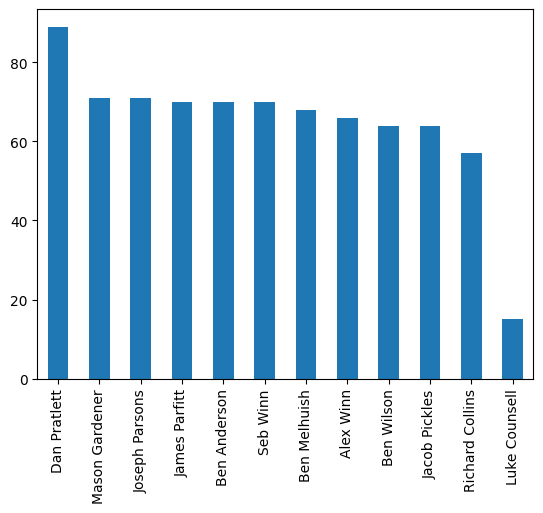

In [65]:
league_teams_df = ldo.league_teams_df.copy()
league_teams_df["player_pick"] = league_teams_df["player_pick"].str.replace(
    r"\(\S\)", "", regex=True
)
a = league_teams_df.groupby("player_pick")["Manager"].unique()
total_unique_player_counts = (
    pd.DataFrame.from_records(a.values.tolist()).stack().value_counts()
)
total_unique_player_counts.plot.bar(x="Manager")

## Mr. (in)consistent

In [66]:
points_spread_df = (
    ldo.season_stats_df.groupby("Manager")["Points"]
    .agg(["mean", "max", std])
    .sort_values(by=["std"], ascending=False)
)
points_spread_df

,mean,max,std
Manager,,,
James Parfitt,66.105263,137,24.587962
Seb Winn,66.789474,139,23.753291
Ben Melhuish,63.447368,113,22.629391
Alex Winn,64.342105,127,21.765831
Joseph Parsons,63.394737,123,20.563815
Luke Counsell,46.500000,87,19.559289
Richard Collins,60.684211,105,19.511272
Mason Gardener,61.421053,106,19.081034
Ben Wilson,56.710526,110,19.013718


<Axes: xlabel='Manager'>

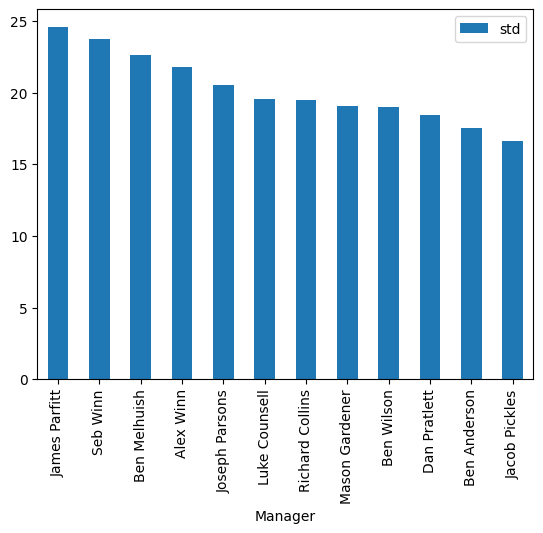

In [67]:
points_spread_df.plot.bar(y="std")

### Gaussian plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

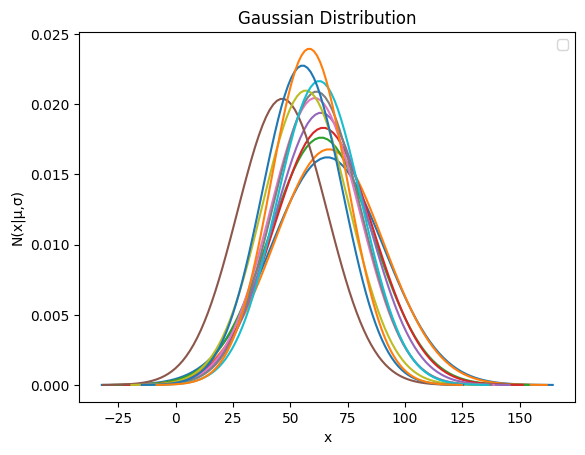

In [68]:
for manager in points_spread_df.index:
    mu = points_spread_df.loc[manager, "mean"]
    sigma = points_spread_df.loc[manager, "std"]
    plot = Gaussian.plot(mu, sigma)
plot.show()

## Saved by the bench

In [69]:
""" for i, (manager_id, manager_name) in enumerate(ldo.manager_id_name_dict.items()):
    print(manager_name)
    count = 0
    for j, gw in enumerate(range(1, ldo.max_gw + 1)):
        #print(gw)
        team_selection_response_json = ldo._get_requests_response(
            ldo.picks_url_template, manager_id=manager_id, gw=gw
        )
        if not team_selection_response_json["automatic_subs"]:
            continue
        auto_subs_df = pd.DataFrame(team_selection_response_json["automatic_subs"])
        count += 1
    print(count) """

### Boringly, it's Luke

' for i, (manager_id, manager_name) in enumerate(ldo.manager_id_name_dict.items()):\n    print(manager_name)\n    count = 0\n    for j, gw in enumerate(range(1, ldo.max_gw + 1)):\n        #print(gw)\n        team_selection_response_json = ldo._get_requests_response(\n            ldo.picks_url_template, manager_id=manager_id, gw=gw\n        )\n        if not team_selection_response_json["automatic_subs"]:\n            continue\n        auto_subs_df = pd.DataFrame(team_selection_response_json["automatic_subs"])\n        count += 1\n    print(count) '

## Anti rhino

In [70]:
### It's Mason

## Best ROI

In [71]:
season_stats_df = ldo.season_stats_df.copy()
season_stats_df["price_per_point"] = season_stats_df["Value"].div(
    season_stats_df["Points"]
)
roi_df = (
    season_stats_df.groupby("Manager")["price_per_point"]
    .agg(["mean", "max", std])
    .sort_values(by=["mean"], ascending=True)
)
roi_df

,mean,max,std
Manager,,,
Joseph Parsons,1.799022e+06,4.369565e+06,6.891790e+05
Seb Winn,1.806625e+06,6.933333e+06,9.978307e+05
Alex Winn,1.811015e+06,4.148000e+06,7.172568e+05
Dan Pratlett,1.842367e+06,5.240000e+06,7.579999e+05
Mason Gardener,1.851215e+06,4.225000e+06,7.033863e+05
Richard Collins,1.853312e+06,3.892308e+06,6.650626e+05
James Parfitt,1.897533e+06,7.006667e+06,1.102273e+06
Jacob Pickles,1.909570e+06,3.280645e+06,5.612167e+05
Ben Melhuish,1.963931e+06,6.940000e+06,1.143524e+06


<Axes: xlabel='Manager'>

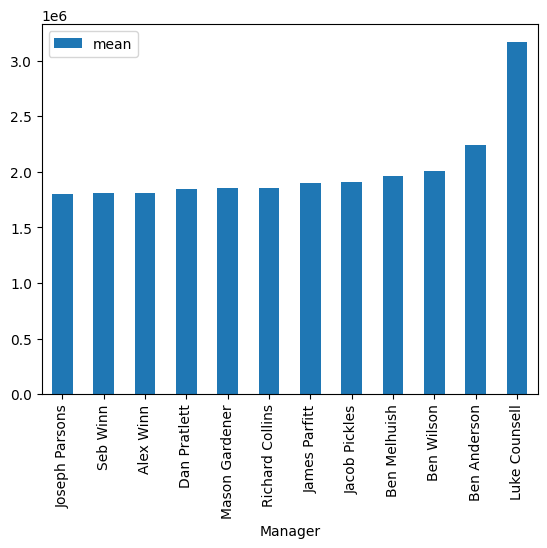

In [72]:
roi_df.plot.bar(y="mean")

## Last minute transfers

In [73]:
transfers_df = ldo.transfers_df.copy()
bootstrap_static_events_df = ldo.bootstrap_static_events_df.copy()

### Merge dataframes
merged_df = pd.merge(
    left=transfers_df,
    right=bootstrap_static_events_df.loc[:, ["id", "deadline_time"]],
    left_on=["GW"],
    right_on=["id"],
    how="outer",
)
### Convert to datetimes
merged_df["time"] = pd.to_datetime(merged_df["time"])
merged_df["deadline_time"] = pd.to_datetime(merged_df["deadline_time"])

### Find time difference
merged_df["time_before_deadline"] = merged_df["deadline_time"] - merged_df["time"]

### Groupby and mean
time_before_deadline_df = (
    merged_df.groupby("Manager")["time_before_deadline"]
    .agg(["mean", "max", std])
    .sort_values(by=["mean"], ascending=True)
)
time_before_deadline_df

,mean,max,std
Manager,,,
Richard Collins,0 days 02:03:45.569311564,0 days 07:51:52.412110,0 days 01:44:03.765217111
Seb Winn,0 days 16:45:20.969892066,3 days 12:30:40.253162,0 days 22:54:19.400126936
Mason Gardener,0 days 19:32:21.548290962,9 days 04:39:54.148234,2 days 00:38:56.916638930
Joseph Parsons,0 days 20:13:24.374406605,12 days 02:23:23.841970,1 days 13:03:28.511018874
Ben Melhuish,1 days 07:54:40.566567819,8 days 10:27:22.721109,1 days 19:43:20.810216338
James Parfitt,1 days 16:52:25.226010058,6 days 16:46:12.856223,2 days 04:43:06.289861282
Alex Winn,2 days 10:17:49.056097659,5 days 02:23:39.335027,1 days 12:51:38.378099710
Ben Wilson,2 days 20:26:49.013283753,10 days 01:04:05.303401,3 days 01:50:05.239409625
Jacob Pickles,4 days 00:22:24.707376952,12 days 19:54:32.604916,2 days 18:55:29.467878873


<Axes: xlabel='Manager'>

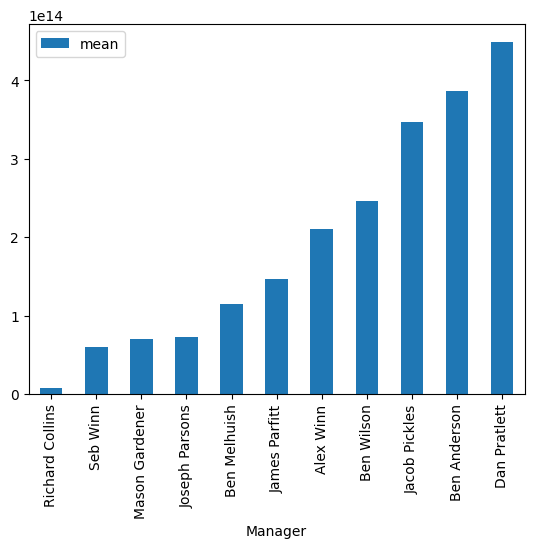

In [74]:
time_before_deadline_df.plot.bar(y="mean")

## Most points on bench

In [75]:
### Seb: 298

## Highest transfer costs

In [76]:
## Ben Anderson: 136

## Lowest highest rank

In [77]:
### Joint Ben Anderson and Wilson: 8